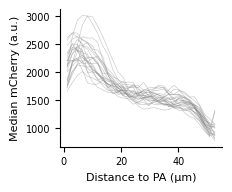

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

class RHLAnalyzer:
    def __init__(self, filepath: str, num_x_bins: int = 30, num_y_bins: int = 30, pixel_to_um: float = 0.065):
        self.filepath = filepath
        self.num_x_bins = num_x_bins
        self.num_y_bins = num_y_bins
        self.pixel_to_um = pixel_to_um
        self.raw_df = None
        self.df = None
        self.x_bins = None
        self.y_bins = None

    def load_data(self):
        """Read CSV into raw_df."""
        self.raw_df = pd.read_csv(self.filepath)
        return self

    def filter_wt(self, col: str = "RHL", wt_value: str = "wt"):
        """Keep only rows where raw_df[col] == wt_value."""
        if self.raw_df is None:
            raise RuntimeError("Call load_data() first.")
        self.df = self.raw_df[self.raw_df[col] == wt_value].copy()
        return self

    def convert_to_um(self, x_col: str = "x", y_col: str = "y"):
        """Convert pixel coordinates to micrometers."""
        if self.df is None:
            raise RuntimeError("Call filter_wt() first.")
        self.df['x_um'] = self.df[x_col] * self.pixel_to_um
        self.df['y_um'] = self.df[y_col] * self.pixel_to_um
        return self

    def define_binning(self, x_col: str = "x_um", y_col: str = "y_um"):
        """Compute bin edges and assign x_bin, y_bin to self.df."""
        if self.df is None:
            raise RuntimeError("Call convert_to_um() first.")

        self.x_bins = np.linspace(self.df[x_col].min(), self.df[x_col].max(), self.num_x_bins + 1)
        self.y_bins = np.linspace(self.df[y_col].min(), self.df[y_col].max(), self.num_y_bins + 1)

        self.df['x_bin'] = np.digitize(self.df[x_col], self.x_bins, right=False) - 1
        self.df['y_bin'] = np.digitize(self.df[y_col], self.y_bins, right=False) - 1

        self.df['x_bin'] = self.df['x_bin'].clip(0, self.num_x_bins - 1)
        self.df['y_bin'] = self.df['y_bin'].clip(0, self.num_y_bins - 1)

        # Calculate bin centers in micrometers
        self.y_bin_centers = (self.y_bins[:-1] + self.y_bins[1:]) / 2
        return self

    def get_replicates(self, selected_replicates=None):
        """Return dict of replicates with exclusions."""
        exclusions = {
            'replicate_1': ['pos3', 'pos7', 'pos8'],
            'replicate_2': [],
            'replicate_3': [],
            'replicate_4': [],
            'replicate_5': []
        }

        if selected_replicates is not None:
            exclusions = {k: v for k, v in exclusions.items() if k in selected_replicates}

        reps = {}
        for rep, exclude in exclusions.items():
            df_rep = self.df[self.df['replicate'] == rep]
            if exclude:
                df_rep = df_rep[~df_rep['pos'].isin(exclude)]
            reps[rep] = df_rep
        return reps

    def plot_all_chambers(self, selected_replicates=None):
        """Line plot of median intensity for every chamber across selected replicates."""
        final_width_cm = 6
        final_height_cm = 5
        final_width_in = final_width_cm / 2.54
        final_height_in = final_height_cm / 2.54
        pnas_fontsize = 8
        plt.rcParams.update({
            'font.size': pnas_fontsize,
            'pdf.fonttype': 42,
            'ps.fonttype': 42
        })

        reps = self.get_replicates(selected_replicates)
        fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

        for rep, df_rep in reps.items():
            for _, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_mcherry'].median().reset_index()
                # Map bin indices to micrometers
                y_um = self.y_bin_centers[stats['y_bin'].values.astype(int)]
                ax.plot(y_um, stats['intensity_raw_mcherry'].values, 
                       color='grey', linewidth=0.5, alpha=0.4)

        ax.set_xlabel('Distance to PA (µm)', fontsize=pnas_fontsize)
        ax.set_ylabel('Median mCherry (a.u.)', fontsize=pnas_fontsize)
        ax.tick_params(labelsize=pnas_fontsize-1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()

    def save_plot_data(self, csv_path: str, selected_replicates=None) -> pd.DataFrame:
        """Save median intensity vs y_um for each replicate and chamber to CSV."""
        reps = self.get_replicates(selected_replicates)
        records = []
        for rep, df_rep in reps.items():
            for pos, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_mcherry'].median().reset_index()
                for _, row in stats.iterrows():
                    bin_idx = int(row['y_bin'])
                    records.append({
                        'replicate': rep,
                        'pos': pos,
                        'y_bin': bin_idx,
                        'y_um': self.y_bin_centers[bin_idx],
                        'median_intensity': row['intensity_raw_mcherry']
                    })
        df_out = pd.DataFrame.from_records(records)
        df_out.to_csv(csv_path, index=False)
        return df_out


if __name__ == '__main__':
    analyzer = (
        RHLAnalyzer(
            filepath='/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Figure_Data/Figure3/RHL_Gradient/0_rhl_gradient.csv',
            num_x_bins=30,
            num_y_bins=30,
            pixel_to_um=0.065
        )
        .load_data()
        .filter_wt()
        .convert_to_um()
        .define_binning()
    )

    selected_reps = ['replicate_4', 'replicate_5', 'replicate_7']
    analyzer.plot_all_chambers(selected_replicates=selected_reps)
    df_data = analyzer.save_plot_data('3D_RHL_Mcherry_gradient_visualization.csv', 
                                      selected_replicates=selected_reps)
    plt.savefig('3D_RHL_Mcherry_gradient_visualization.pdf', dpi=300, transparent=True)
    #plt.savefig('3D_RHL_Mcherry_gradient_visualization.png', dpi=300, transparent=True)
    plt.show()
